# Benchmarking circuits for Qiskit

![Qiskit logo](img/qiskit-heading.png)

This work provides a collection of quantum circuits that can be used to benchmark Qiskit, to keep track of the impact of the changes on its performance as codebase evolves or simply assert it at a given point in time.

The quantum circuits provided both span useful building blocks for larger quantum circuits, as well as application-related circuits. A few examples of the currently available ones are:

- random circuits
- QFT
- n-Toffoli gate
- variational circuits for quantum chemistry (UCCSD)

Users can compute various metrics on these `QuantumCircuit` objects by accesing for example their width, depth, gate count, or runtime on either a simulator or QPU, before or after optimizations are performed. These metrics can then be used to assert the performance of various modules of Qiskit, or the feasibility of an approach on a backend with limited capabilities such as memory or coherence time.

These circuits have parameters, so that one can observe how the desired metrics scale with input size.

This list can be expanded to various other types of circuits such as adders, Grover for a random oracle, magic state factory, quantum error-correcting code and many others.

## General-purpose quantum circuits

These circuits are building blocks that are used in a wide array or larger circuits. They are formulated at the highest-level of abstraction.

In [1]:
from circuit_benchmarks.toffoli import toffoli
toffoli(4).draw()

QiskitError: 'expected integer index into register'

In [ ]:
from circuit_benchmarks.ripple_adder import ripple_adder
ripple_adder(10).draw()

In [ ]:
from networkx import grid_2d_graph, hexagonal_lattice_graph, triangular_lattice_graph, to_edgelist, draw, kamada_kawai_layout, convert_node_labels_to_integers

def square_grid_adj(n, m):
    nxgraph = grid_2d_graph(n, m)
    nodelist = list(nxgraph.nodes)
    return [[nodelist.index(n1),nodelist.index(n2)] for n1, n2, _ in to_edgelist(nxgraph)]
def hex_grid_adj(n, m):
    nxgraph = hexagonal_lattice_graph(n, m)
    nodelist = list(nxgraph.nodes)
    return [[nodelist.index(n1),nodelist.index(n2)] for n1, n2, _ in to_edgelist(nxgraph)]
def tri_grid_adj(n, m):
    nxgraph = triangular_lattice_graph(n, m)
    nodelist = list(nxgraph.nodes)
    return [[nodelist.index(n1),nodelist.index(n2)] for n1, n2, _ in to_edgelist(nxgraph)]

grid_graphs = [square_grid_adj(n,n) for n in range(2,22)]
hex_graphs = [hex_grid_adj(n,n) for n in range(2,22)]
tri_graphs = [tri_grid_adj(n,n) for n in range(2,22)]

In [ ]:
from qiskit.mapper import CouplingMap

grid_couplm = [CouplingMap(l) for l in grid_graphs]
hex_couplm =  [CouplingMap(l) for l in hex_graphs]
tri_couplm =  [CouplingMap(l) for l in tri_graphs]

In [ ]:
g = grid_2d_graph(3,3)
pos = kamada_kawai_layout(g)
draw(g, pos)

In [ ]:
g = hexagonal_lattice_graph(3,3)
pos = kamada_kawai_layout(g)
draw(g, pos)

In [ ]:
from qiskit.circuit import QuantumCircuit
from qiskit.mapper import CouplingMap, swap_mapper
from qiskit.tools.parallel import parallel_map
from qiskit.converters import circuit_to_dag
from qiskit.converters import dag_to_circuit
from qiskit.extensions.standard import SwapGate
from qiskit.mapper import Layout
from qiskit.transpiler.passes.unroller import Unroller
import copy

from qiskit.transpiler.passes.cx_cancellation import CXCancellation
from qiskit.transpiler.passes.decompose import Decompose
from qiskit.transpiler.passes.optimize_1q_gates import Optimize1qGates
from qiskit.transpiler.passes.mapping.barrier_before_final_measurements import BarrierBeforeFinalMeasurements
from qiskit.transpiler.passes.mapping.check_cnot_direction import CheckCnotDirection
from qiskit.transpiler.passes.mapping.cx_direction import CXDirection
from qiskit.transpiler.passes.mapping.dense_layout import DenseLayout
from qiskit.transpiler.passes.mapping.trivial_layout import TrivialLayout
from qiskit.dagcircuit import DAGCircuit

basis_gates = ['u1','u2','u3','cx','id']
# An example of UCCSD circuit for a given molecular system and basis, printed?
def default_map(dag, coupling):
    dag = copy.deepcopy(dag)
    dag = Unroller(basis_gates).run(dag)
    dag = BarrierBeforeFinalMeasurements().run(dag)
    
    check_cnot_direction = CheckCnotDirection(coupling)
    check_cnot_direction.run(dag)
    if check_cnot_direction.property_set['is_direction_mapped']:
        trivial_layout = TrivialLayout(coupling)
        trivial_layout.run(dag)
        initial_layout = trivial_layout.property_set['layout']
    else:
        dense_layout = DenseLayout(coupling)
        dense_layout.run(dag)
        initial_layout = dense_layout.property_set['layout']


    dag, final_layout = swap_mapper(
        dag, coupling, initial_layout, trials=20, seed=seed_mapper)
    # Expand swaps
    dag = Decompose(SwapGate).run(dag)
    # Change cx directions
    dag = CXDirection(coupling).run(dag)
    # Simplify cx gates
    dag = CXCancellation().run(dag)
    # Unroll to the basis
    dag = Unroller(['u1', 'u2', 'u3', 'id', 'cx']).run(dag)
    # Simplify single qubit gates
    dag = Optimize1qGates().run(dag)
    return dag

from qiskit.transpiler.passes import LookaheadSwap
def lookahead_map(dag, coupling):
    dag = copy.deepcopy(dag)
    dag = Unroller(basis_gates).run(dag)
    dag = BarrierBeforeFinalMeasurements().run(dag)

    la_swap = LookaheadSwap(coupling)
    la_swap.run(dag)
    # Expand swaps
    dag = Decompose(SwapGate).run(dag)
    # Change cx directions
    dag = CXDirection(coupling).run(dag)
    # Simplify cx gates
    dag = CXCancellation().run(dag)
    # Unroll to the basis
    dag = Unroller(['u1', 'u2', 'u3', 'id', 'cx']).run(dag)
    # Simplify single qubit gates
    dag = Optimize1qGates().run(dag)
    return dag

## QFT Circuits
Quantum Fourier Transform is a very important subcircuit for many applications.

In [ ]:
from circuit_benchmarks.qft import qft

for grid in grids:
    nr_qubits = grid.size()
    qft = qft(nr_qubits)
    default_mapped_dag = default_map(qft, grid)
    la_mapped_dag = lookahead_map(qft, grid)
    
dag = circuit_to_dag(qft8)
default_map(dag, CouplingMap())

## Application-specific quantum circuits

These circuits directly provide a way for users to benchmark the performance of Qiskit over particular applications of interest, and evaluate the feasibility of an approach on a target hardware, for example (runtime, hardware constraints on quantum volume...).

### Varitonal circuits in quantum chemistry

Some of these circuits are tied to a given problem, defined for example by a molecule and a basis set. The number of qubits required by these circuits, as well as the number of parameters used for the variational search is then determined accordingly. That is, these circuits cannot be simply fully-defined by a number of qubits provided as input; this is the case of the UCCSD variational form, for example. However, one can still observe how different metrics scale for these circuits by varying problem size (e.g the molecule or basis set), which makes sense for users that are focused on concrete applications in the field.

In [2]:
# A list of molecules to use in benchmarking (can be grown larger by Qiskit users)
H2 = 'H .0 .0 .0; H .0 .0 0.735'
LiH = 'Li .0 .0 .0; H .0 .0 1.6'
NaH = 'Na .0 .0 .0; H .0 .0 1.9'
molecules = [H2, LiH, NaH]

# A list of bases to use in benchmarking (can be grown larger by Qiskit users)
bases = ['sto3g', '631g', 'ccpVDZ']

In [3]:
import numpy as np
from qiskit_chemistry.drivers import PySCFDriver, UnitsType
from circuit_benchmarks.UCCSD import UCCSD_qc

from qiskit import BasicAer, execute
import time

# How the q.c width, depth and performance scale with molecule size, for a given basis
widths, depths, runtimes = [], [], []
for m in molecules:
    qc = UCCSD_qc((m, 'sto3g', UnitsType.ANGSTROM), active_occupied=[], active_unoccupied=[],
                   map_type='parity', two_qubit_reduction=False,
                   depth=1)
    widths.append(qc.width())
    depths.append(qc.depth())

    t_start=time.time()
    job = execute(qc, BasicAer.get_backend('statevector_simulator'))
    t_elapsed = time.time() - t_start
    runtimes.append(t_elapsed)

The code provides functions allowing to generate these UCCSD circuits for various molecules, basis sets and active spaces. The benchmark can be enriched by users, inputing their own problem and adding the corresponding circuit to the benchmark.

This approach can be generalized easily to different ansatz, or active spaces, allowing the user to determine what is the best approach to running for example VQE. They could then identiify the feasible approaches on the target hardware, and the parameters yielding the most appealing performance-accuracy trade-off.

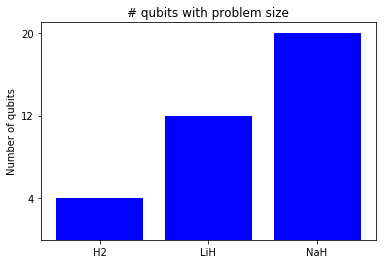

In [4]:
import matplotlib.pyplot as plt; plt.rcdefaults()
import numpy as np
import matplotlib.pyplot as plt
%matplotlib inline
    
labels = ('H2', 'LiH', 'NaH')
y_pos = np.arange(len(labels))

plt.bar(y_pos, widths, align='center', alpha=1.0, color = "blue")
plt.xticks(y_pos, labels)
plt.yticks(widths)
plt.ylabel('Number of qubits')
plt.title('# qubits with problem size')
plt.show()

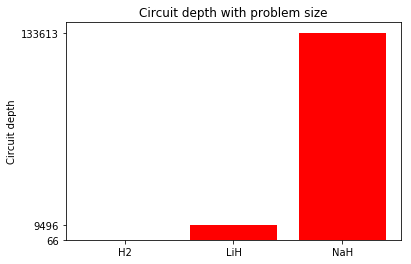

In [5]:
plt.bar(y_pos, depths, align='center', alpha=1.0, color = "red")
plt.xticks(y_pos, labels)
plt.yticks(depths)
plt.ylabel('Circuit depth')
plt.title('Circuit depth with problem size')
plt.show()

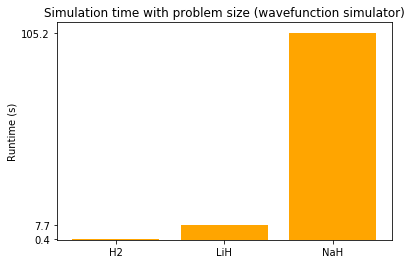

In [6]:
plt.bar(y_pos, runtimes, align='center', alpha=1.0, color = "orange")
plt.xticks(y_pos, labels)
plt.yticks(runtimes)
plt.ylabel('Runtime (s)')
plt.title('Simulation time with problem size (wavefunction simulator)')
plt.show()

# Magic State Factory

In [ ]:
from circuit_benchmarks.distillation_protocols import reed_muller_15

In [ ]:
f = reed_muller_15().draw(output='mpl')

In [ ]:
f